In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# 2017 Aja Rangaswamy (aja004@gmail.com)                              #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################
#######################################################################
# Copyright (C)                                                       #
# 2017 Cheung Auyeung(cheung.auyeung@gmail.com)                       #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

Figure 4.2 shows the sequence of policies found by policy iteration starting from the
policy that never moves any cars.

In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import *
import time 

In [3]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        print('%r  %2.2f s' % \
            (method.__name__, (te - ts) ))
        return result

    return timed

# Example 4.2 Car Rental 

Jack’s Car Rental Jack manages **two locations** for a nationwide
car rental company. Each day, some number of customers arrive at each location
to rent cars. 

If Jack has a car available, he rents it out and is **credited \$10** (`RENTAL_CREDIT`) per car rented by the
national company. If he is out of cars at that location, then the business is lost.
Cars become available for renting the day after they are returned. 

To help ensure
that cars are available where they are needed, Jack can move them between the two
locations overnight, at a **cost of \$2** (`MOVE_CAR_COST`) per car moved. 

We assume that the number of
cars **requested and returned** at each location are ***Poisson random variables***, meaning
that the probability that the number is n is $\frac{\lambda^n}{n!}e^{-\lambda}$, 
where $\lambda$ is the expected number.
Suppose $\lambda$ is
- 3 (`RENTAL_REQUEST_FIRST_LOC`) and 4 (`RENTAL_REQUEST_SECOND_LOC`) for rental requests at the first and second locations and 
- 3 (`RETURNS_FIRST_LOC`) and 2 (`RETURNS_SECOND_LOC`) for returns. 

To simplify the problem slightly, we assume that there can be **no more
than 20** cars (`MAX_CARS`) at each location (any **additional cars** are returned to the nationwide
company, and thus ***disappear*** from the problem) and a **maximum of five cars** (`MAX_MOVE_OF_CARS`) can
be moved from one location to the other in one night. 

We take the **discount rateto be $\gamma = 0.9$** (`DISCOUNT `) and formulate this as a continuing finite MDP, where 
- the **time steps** are days, 
- the **state** is the number of cars at each location at the end of the day, and
- the **actions** are the net numbers of cars moved between the two locations overnight.

In [4]:
# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2

DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2

In [5]:
# all possible states
states = []

# axes for printing use
AxisXPrint = []
AxisYPrint = []
for i in range(0, MAX_CARS + 1):
    for j in range(0, MAX_CARS + 1):
        AxisXPrint.append(i)
        AxisYPrint.append(j)
        states.append([i, j])

In [22]:
# plot a policy/state value matrix
figureIndex = 0
def prettyPrint(data, labels):
    global figureIndex
    figureIndex += 1
    fig = plt.figure(figureIndex)
    plt.matshow(data,cmap="jet")
    plt.colorbar()
    plt.show()
    
    figureIndex += 1
    fig = plt.figure(figureIndex)   
    ax = fig.add_subplot(111, projection='3d')
    AxisZ = []
    for i, j in states:
        AxisZ.append(data[i, j])
    ax.scatter(AxisXPrint, AxisYPrint, AxisZ)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])

## Poisson random variables

The probability mass function of a Poission random varabile $n$ is $P(n\,;\,\lambda) = \frac{\lambda^n}{n!}e^{-\lambda}$, 
where $\lambda$ is the expected number.

To avoid recomputing $P(n\,;\,\lambda)$ (`poisson(n, lam)`) for repeated values of $(n,\lambda)$, use a lookup table `poissonLUT[key]` to store the corresponding value on condition that $n < 11$ (`POISSON_UP_BOUND`) where
```python
    key = n * 10 + lam
```
and `lam` is $\lambda$.

In [7]:
# An up bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0
POISSON_UP_BOUND = 11

# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poissonLUT = dict()
def poisson(n, lam):
    global poissonBackup
    key = n * 10 + lam
    if key not in poissonLUT.keys():
        poissonLUT[key] = exp(-lam) * pow(lam, n) / factorial(n)
    return poissonLUT[key]

# Figure 4.2: Policy Iteration Example

Print the sequence of policies found by combining value iteration and policy iteration on Jack’s car rental problem,
and the final state-value function. 

## Value-Policy Iteration


In [8]:
# @state: [# of cars in first location, # of cars in second location]
# @action: positive if moving cars from first location to second location,
#          negative if moving cars from second location to first location
# @stateValue: state value matrix
def expectedReturn(state, action, stateValue):
    # initailize total return
    returns = 0.0

    # cost for moving cars
    returns -= MOVE_CAR_COST * abs(action)

    # go through all possible rental requests
    for rentalRequestFirstLoc in range(0, POISSON_UP_BOUND):
        for rentalRequestSecondLoc in range(0, POISSON_UP_BOUND):
            # moving cars
            numOfCarsFirstLoc = int(min(state[0] - action, MAX_CARS))
            numOfCarsSecondLoc = int(min(state[1] + action, MAX_CARS))

            # valid rental requests should be less than actual # of cars
            realRentalFirstLoc = min(numOfCarsFirstLoc, rentalRequestFirstLoc)
            realRentalSecondLoc = min(numOfCarsSecondLoc, rentalRequestSecondLoc)

            # get credits for renting
            reward = (realRentalFirstLoc + realRentalSecondLoc) * RENTAL_CREDIT
            numOfCarsFirstLoc -= realRentalFirstLoc
            numOfCarsSecondLoc -= realRentalSecondLoc

            # probability for current combination of rental requests
            prob = poisson(rentalRequestFirstLoc, RENTAL_REQUEST_FIRST_LOC) * \
                         poisson(rentalRequestSecondLoc, RENTAL_REQUEST_SECOND_LOC)

            # if set True, model is simplified such that the # of cars returned in daytime becomes constant
            # rather than a random value from poisson distribution, which will reduce calculation time
            # and leave the optimal policy/value state matrix almost the same
            constantReturnedCars = True
            if constantReturnedCars:
                # get returned cars, those cars can be used for renting tomorrow
                returnedCarsFirstLoc = RETURNS_FIRST_LOC
                returnedCarsSecondLoc = RETURNS_SECOND_LOC
                numOfCarsFirstLoc = min(numOfCarsFirstLoc + returnedCarsFirstLoc, MAX_CARS)
                numOfCarsSecondLoc = min(numOfCarsSecondLoc + returnedCarsSecondLoc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * stateValue[numOfCarsFirstLoc, numOfCarsSecondLoc])
            else:
                numOfCarsFirstLoc_ = numOfCarsFirstLoc
                numOfCarsSecondLoc_ = numOfCarsSecondLoc
                prob_ = prob
                for returnedCarsFirstLoc in range(0, POISSON_UP_BOUND):
                    for returnedCarsSecondLoc in range(0, POISSON_UP_BOUND):
                        numOfCarsFirstLoc = numOfCarsFirstLoc_
                        numOfCarsSecondLoc = numOfCarsSecondLoc_
                        prob = prob_
                        numOfCarsFirstLoc = min(numOfCarsFirstLoc + returnedCarsFirstLoc, MAX_CARS)
                        numOfCarsSecondLoc = min(numOfCarsSecondLoc + returnedCarsSecondLoc, MAX_CARS)
                        prob = poisson(returnedCarsFirstLoc, RETURNS_FIRST_LOC) * \
                               poisson(returnedCarsSecondLoc, RETURNS_SECOND_LOC) * prob
                        returns += prob * (reward + DISCOUNT * stateValue[numOfCarsFirstLoc, numOfCarsSecondLoc])
    return returns

1. Initialization
V (s) 2 R and π(s) 2 A(s) arbitrarily for all s 2 S

2. Policy Evaluation
Repeat
∆ 0
For each s 2 S:
v V (s)
V (s) Ps0;r p(s0; rjs; π(s))r + γV (s0)
∆ max(∆; jv − V (s)j)
until ∆ < θ (a small positive number)

3. Policy Improvement
policy-stable true
For each s 2 S:
old-action π(s)
π(s) argmaxa Ps0;r p(s0; rjs; a)r + γV (s0)
If old-action 6= π(s), then policy-stable false
If policy-stable, then stop and return V ≈ v∗ and π ≈ π∗; else go to 2

In [ ]:
# current policy
policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

# current state value
stateValue = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

# all possible actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

newStateValue = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
improvePolicy = False
policyImprovementInd = 0
while True:
    if improvePolicy == True:
        # start policy improvement
        print('Policy improvement', policyImprovementInd)
        policyImprovementInd += 1
        newPolicy = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
        ts = time.time()
        for i, j in states:
            actionReturns = []
            # go through all actions and select the best one
            for action in actions:
                if (action >= 0 and i >= action) or (action < 0 and j >= abs(action)):
                    actionReturns.append(expectedReturn([i, j], action, stateValue))
                else:
                    actionReturns.append(-float('inf'))
            bestAction = np.argmax(actionReturns)
            newPolicy[i, j] = actions[bestAction]
        te = time.time()
        print('Elapse Time for Policy improvement = {:2.4f} s'.format(te - ts))

        plt.matshow(newPolicy,cmap="jet")
        plt.colorbar()
        plt.show()        
        
        # if policy is stable
        policyChanges = np.sum(newPolicy != policy)
        print('New policy has', policyChanges, 'states changed')

        if policyChanges == 0:
            policy = newPolicy
            break
        policy = newPolicy
        improvePolicy = False
        
    # start policy evaluation
    for i, j in states:
        newStateValue[i, j] = expectedReturn([i, j], policy[i, j], stateValue)
    if np.sum(np.abs(newStateValue - stateValue)) < 1e-4:
        stateValue[:] = newStateValue
        improvePolicy = True
        continue
    stateValue[:] = newStateValue

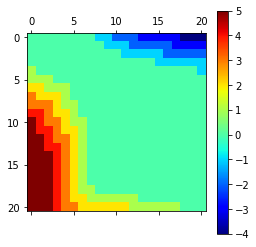

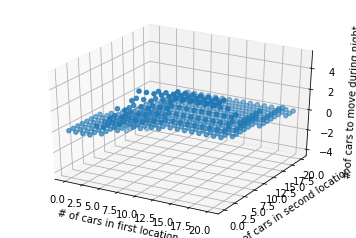

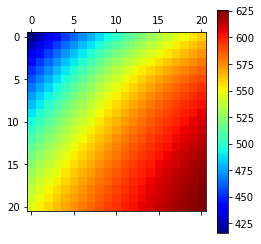

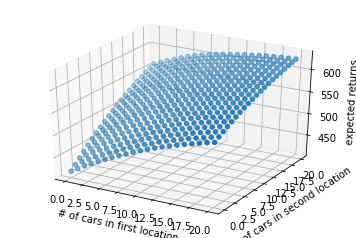

In [23]:
prettyPrint(policy, ['# of cars in first location', '# of cars in second location', '# of cars to move during night'])
plt.show()

prettyPrint(stateValue, ['# of cars in first location', '# of cars in second location', 'expected returns'])
plt.show()